In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym
import math
import numpy as np
torch.set_default_dtype(torch.float64)

total_epsoide = 2000
max_epsoide_step = 200
update_step = 10

worker_dim = 4
gamma = 0.9
env = gym.make("Pendulum-v0")

state_dim = env.observation_space.shape[0]
hidden_dim = 256
action_dim = env.action_space.shape[0]
statistical_length = 40

class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr):
        super().__init__(params, lr=lr)

def v_wrap(np_array, dtype=np.float64):
    if np_array.dtype != dtype:
        np_array = np_array.astype(dtype)
    return torch.from_numpy(np_array)


def push_and_pull(optimizer, local_net, global_net, done, new_state,
                  buf_state, buf_action, buf_reward):
    if done:
        new_value = 0.  # terminal
    else:
        new_value = local_net.forward(v_wrap(new_state[None, :]))[-1].data.numpy()[0, 0]
    buffer_value_target = []
    for reward in buf_reward[::-1]:  # reverse buffer r
        new_value = reward + gamma * new_value
        buffer_value_target.append(new_value)
    buffer_value_target.reverse()

    loss = local_net.loss_func(
        v_wrap(np.vstack(buf_state)),
        v_wrap(np.array(buf_action), dtype=np.int64) if buf_action[0].dtype == np.int64 else v_wrap(
            np.vstack(buf_action)),
        v_wrap(np.array(buffer_value_target)[:, None]))
    # calculate local gradients and push local parameters to global
    optimizer.zero_grad()
    loss.backward()
    for local_param, global_param in zip(local_net.parameters(), global_net.parameters()):
        global_param._grad = local_param.grad
    optimizer.step()
    # pull global parameters
    local_net.load_state_dict(global_net.state_dict())

class Actor_Critic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_actor = nn.Linear(state_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.std = nn.Linear(hidden_dim, action_dim)

        self.linear_critic = nn.Linear(state_dim, hidden_dim)
        self.values = nn.Linear(hidden_dim, 1)

        for layer in [self.linear_actor, self.mean, self.std]:
            nn.init.normal_(layer.weight, mean=0., std=0.1)
            nn.init.constant_(layer.bias, 0.)
        self.distribution = torch.distributions.Normal

    def forward(self, state):
        linear_actor = F.relu6(self.linear_actor(state))
        mean = 2 * torch.tanh(self.mean(linear_actor))
        std = F.softplus(self.std(linear_actor))
        linear_critic = F.relu6(self.linear_critic(state))
        values = self.values(linear_critic)
        return mean, std, values

    def choose_action(self, state):
        self.training = False
        mean, std, _ = self.forward(state)
        normal = self.distribution(mean.view(1, ).data, std.view(1, ).data)
        return normal.sample().numpy()

    def loss_func(self, state, action, value_target):

        mean, std, values = self.forward(state)
        td_error = value_target - values
        critic_loss = td_error.pow(2)

        normal = self.distribution(mean, std)
        log_prob = normal.log_prob(action)
        
        expect_value = log_prob * td_error.detach()
        actor_loss = -expect_value
        total_loss = (actor_loss + critic_loss).mean()
        return total_loss

class Worker(mp.Process):
    def __init__(self, global_net, name, global_optimizer, global_epsoide,
                 global_epsoide_reward, res_queue):
        super(Worker, self).__init__()
        self.name = 'w%i' % name
        self.global_net, self.optimizer = global_net, global_optimizer
        self.local_net = Actor_Critic()
        self.env = gym.make('Pendulum-v0').unwrapped

        self.global_epsoide = global_epsoide
        self.global_epsoide_reward = global_epsoide_reward
        self.res_queue = res_queue

    def run(self):
        total_step = 1
        reward_calculate = 0
        global reward_array
        while self.global_epsoide.value < total_epsoide:
            state = self.env.reset()
            buf_state, buf_action, buf_reward = [], [], []
            total_reward = 0.
            for step in range(max_epsoide_step):

                state = state.astype(np.double)
                action = self.local_net.choose_action(v_wrap(state[None, :]))
                new_state, reward, done, _ = self.env.step(action.clip(-2, 2))

                total_reward += reward
                buf_action.append(action), buf_state.append(state), buf_reward.append(reward / 8 + 1)

                if total_step % update_step == 0 or done:
                    push_and_pull(self.optimizer,
                                  self.local_net, self.global_net,
                                  done,
                                  new_state, buf_state, buf_action, buf_reward)
                    buf_state, buf_action, buf_reward = [], [], []

                state = new_state
                total_step += 1

            self.global_epsoide.value += 1
            self.global_epsoide_reward.value += total_reward

            if self.global_epsoide.value % statistical_length == 0:
                reward = self.global_epsoide_reward.value / statistical_length
                print(self.name, "global_epsoide ", self.global_epsoide.value,
                      "reward_calculate", reward)
                self.res_queue.put(reward)
                self.global_epsoide_reward.value = 0

if __name__ == "__main__":
    global_net = Actor_Critic()  # global network
    global_net.share_memory()  # share the global parameters in multiprocessing
    global_optimizer = SharedAdam(global_net.parameters(), lr=0.0001)  # global optimizer
    global_epsoide, global_epsoide_reward, res_queue = mp.Value('i', 0), mp.Value('d', 0), mp.Queue()
    # parallel training
    workers = [Worker(global_net, i, global_optimizer, global_epsoide, global_epsoide_reward, res_queue) 
              for i in range(worker_dim)]
    [w.start() for w in workers]
    [w.join() for w in workers]

    res_queue.put(None)
    res = []  # record episode reward to plot
    while True:
        r = res_queue.get()
        if r is not None:
            res.append(r)
        else:
            break

w3 global_epsoide  40 reward_calculate -1363.7914777898673
w3 global_epsoide  80 reward_calculate -1328.3827245415187
w3 global_epsoide  120 reward_calculate -1368.4344266538778
w3 global_epsoide  160 reward_calculate -1283.679186499553
w0 global_epsoide  200 reward_calculate -1204.5513739303892
w1 global_epsoide  240 reward_calculate -1272.8625474750015
w3 global_epsoide  280 reward_calculate -1243.4988549799698
w1 global_epsoide  320 reward_calculate -1184.6884998084988
w3 global_epsoide  360 reward_calculate -1170.50649069373
w3 global_epsoide  400 reward_calculate -1089.1722434014666
w2 global_epsoide  440 reward_calculate -998.7018559712787
w2 global_epsoide  480 reward_calculate -992.2246396847843
w1 global_epsoide  520 reward_calculate -957.2058889528604
w2 global_epsoide  560 reward_calculate -947.4093259416643
w2 global_epsoide  600 reward_calculate -987.2244486091619
w2 global_epsoide  640 reward_calculate -814.3548196034974
w2 global_epsoide  680 reward_calculate -796.320748


"""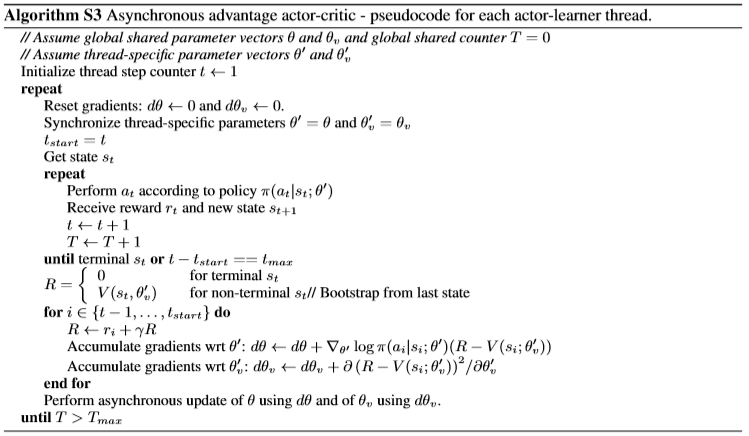"""


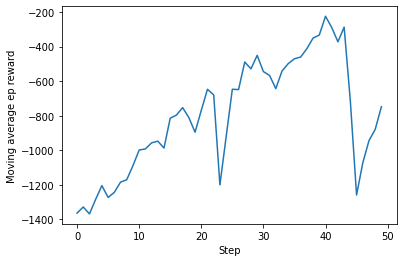

In [2]:
import matplotlib.pyplot as plt
plt.plot(res)
plt.ylabel('Moving average ep reward')
plt.xlabel('Step')
plt.show()